In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import keras_tuner as kt

This is the preprocessed dataset from phase 1.

In [2]:
data = pd.read_csv('dataset.csv')
data.head(5)

,track_name,album_name,artists,explicit,key,mode,time_signature,danceability,energy,loudness,...,week_of_year,day,day_of_week,day_of_year,duration_mins,duration_ms,artist_count,genre_count,track_genre,popularity
0,Ode To The Mets,The New Abnormal,['The Strokes'],False,1,0,4.0,0.4280,0.617,-5.424,...,15,10,Friday,101,5.863117,351787,1,2,"['alt-rock', 'garage']",67
1,Glaciers,Bloom,['Lights & Motion'],False,7,1,4.0,0.0789,0.160,-18.144,...,5,2,Friday,33,2.939550,176373,1,1,['ambient'],49
2,Uber Pussy,Pink Season,['Pink Guy'],True,7,1,4.0,0.8700,0.597,-6.320,...,1,4,Wednesday,4,1.956017,117361,1,1,['comedy'],39
3,2002,Speak Your Mind (Deluxe),['Anne-Marie'],False,1,0,4.0,0.6970,0.683,-2.881,...,17,27,Friday,117,3.116450,186987,1,3,"['dance', 'house', 'pop']",82
4,Monsters You Made (feat. Chris Martin),Twice As Tall,"['Burna Boy', 'Chris Martin']",True,7,0,4.0,0.6710,0.646,-7.513,...,33,13,Thursday,226,3.625683,217541,2,1,['dancehall'],45


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4724 entries, 0 to 4723
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        4724 non-null   object 
 1   album_name        4724 non-null   object 
 2   artists           4724 non-null   object 
 3   explicit          4724 non-null   bool   
 4   key               4724 non-null   int64  
 5   mode              4724 non-null   int64  
 6   time_signature    4724 non-null   float64
 7   danceability      4724 non-null   float64
 8   energy            4724 non-null   float64
 9   loudness          4724 non-null   float64
 10  speechiness       4724 non-null   float64
 11  acousticness      4724 non-null   float64
 12  instrumentalness  4724 non-null   float64
 13  liveness          4724 non-null   float64
 14  valence           4724 non-null   float64
 15  tempo             4724 non-null   float64
 16  track_id          4724 non-null   object 


### Part 3: Dimensionality Reduction

Remove ID columns because they are not useful for the model.

In [4]:
data = data.drop(['track_id', 'album_id', 'artist_ids'], axis=1)

In [5]:
non_numeric_cols = data.select_dtypes(exclude=['int', 'float', 'bool']).columns
for col in non_numeric_cols:
    print(f'{col}: {data[col].dtype}')

track_name: object
album_name: object
artists: object
release_date: object
day_of_week: object
track_genre: object


As we extracted the date information, we can remove the original date columns.

In [6]:
data = data.drop(['release_date'], axis=1)

In [7]:
non_numeric_cols = data.select_dtypes(exclude=['int', 'float', 'bool']).columns
for col in non_numeric_cols:
    print(f'{col}: {data[col].dtype}')

track_name: object
album_name: object
artists: object
day_of_week: object
track_genre: object


In [8]:
# count unique values in artists column
data['artists'].nunique()


2051

In [9]:
X = data.drop(columns=['popularity'])
y = data['popularity']

In [10]:
categorical_features = ['track_genre']
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

X_processed = preprocessor.fit_transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3779, 382), (945, 382), (3779,), (945,))

### Train and Test Data

In [12]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer with 128 neurons
    Dropout(0.2),  # Dropout layer to prevent overfitting
    Dense(64, activation='relu'),  # Second hidden layer with 64 neurons
    Dropout(0.2),  # Dropout layer
    Dense(32, activation='relu'),  # Third hidden layer with 32 neurons
    Dense(1)  # Output layer with 1 neuron for regression
])

model.compile(optimizer='adam',
              loss='mean_squared_error',  # MSE is a common loss function for regression
              metrics=['mean_absolute_error'])  # MAE is a useful metric for regression

C:\Users\apady\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
def fit_and_predict(model, X_train, y_train, X_test, y_test, epochs=20, validation_split=0.2, batch_size=10):
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split, batch_size=batch_size)
    y_pred = model.predict(X_test)

    return history, y_pred

In [14]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    history, y_pred = fit_and_predict(model, X_train, y_train, X_test, y_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.title('True vs Predicted Popularity')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1255.2410 - mean_absolute_error: 28.6829 - val_loss: 226.9391 - val_mean_absolute_error: 12.0106
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 235.2193 - mean_absolute_error: 12.3663 - val_loss: 195.1449 - val_mean_absolute_error: 11.0742
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 179.4164 - mean_absolute_error: 10.6325 - val_loss: 152.1306 - val_mean_absolute_error: 9.6917
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 155.5247 - mean_absolute_error: 9.8223 - val_loss: 142.6351 - val_mean_absolute_error: 9.3875
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 127.2544 - mean_absolute_error: 8.6565 - val_loss: 137.9855 - val_mean_absolute_error: 8.9104
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 117.2371 - mean_absolute_error: 8.3829 - val_loss: 141.0123 - val_mean_absolute_error: 8.9463
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 122.7240 -

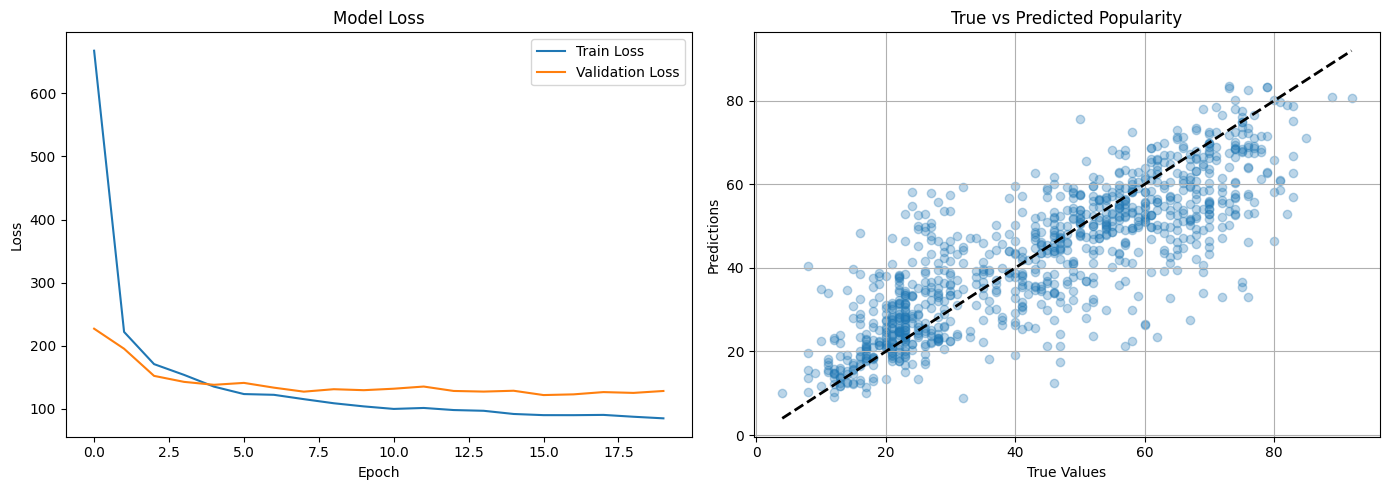

In [15]:
evaluate_model(model, X_train, y_train, X_test, y_test)

In [16]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-4, 1e-3, 1e-2])), loss='mse', metrics=['mse'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='tune_keras')

tuner.search(X_train, y_train, epochs=15, validation_split=0.2, batch_size=32)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first layer is {best_hps.get('units_1')},
the second layer is {best_hps.get('units_2')}, the third layer is {best_hps.get('units_3')}, and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

model = tuner.hypermodel.build(best_hps)

Trial 10 Complete [00h 00m 21s]
val_loss: 239.56234741210938

Best val_loss So Far: 127.30286661783855
Total elapsed time: 00h 04m 11s

The hyperparameter search is complete. The optimal number of units in the first layer is 96,
the second layer is 96, the third layer is 32, and the optimal learning rate for the optimizer
is 0.01.



Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 518.7990 - mse: 518.7990 - val_loss: 165.0508 - val_mse: 165.0508
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 138.8171 - mse: 138.8171 - val_loss: 147.5390 - val_mse: 147.5390
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 120.6445 - mse: 120.6445 - val_loss: 158.1136 - val_mse: 158.1136
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 107.0726 - mse: 107.0726 - val_loss: 150.6115 - val_mse: 150.6115
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 101.7772 - mse: 101.7772 - val_loss: 129.9822 - val_mse: 129.9822
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 90.2029 - mse: 90.2029 - val_loss: 133.4252 - val_mse: 133.4252
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 90.1906 - mse: 90.1906 - val_loss: 138.5734 - val_mse: 138.5734
Epoch 8/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 82.6154 - mse: 82.6154 - val_loss: 122.0810 - val_mse: 122.081

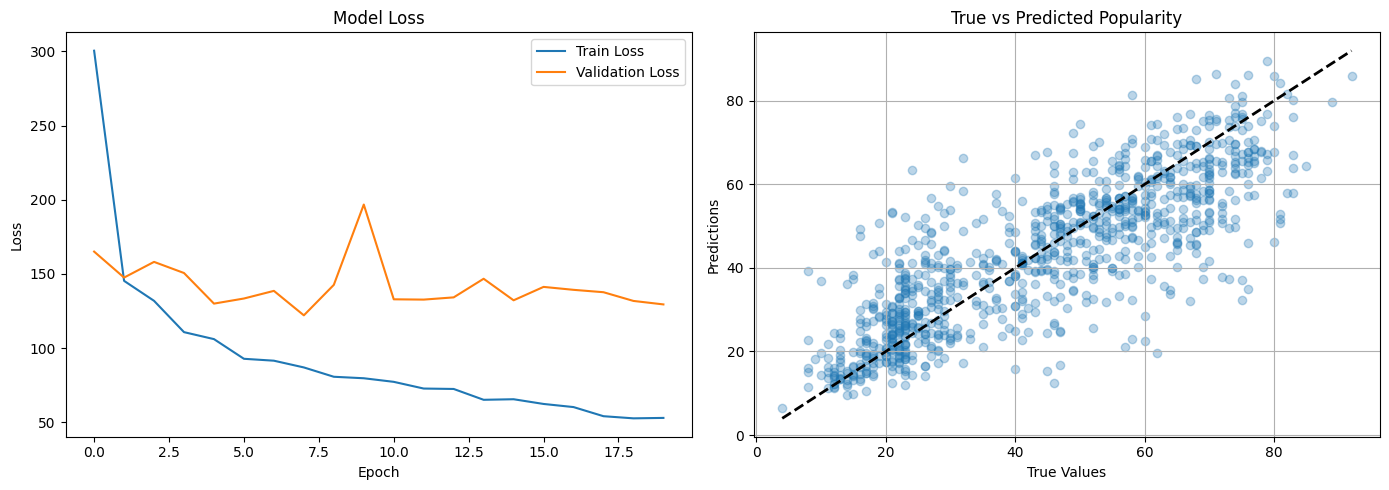

In [17]:
evaluate_model(model, X_train, y_train, X_test, y_test)